In [77]:
#install pandas
#install pandas
import math
import numpy as np
import scipy as sp
import numpy.random as npr  
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.random as npr
import datetime
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from numpy.fft import *
import seaborn as sns
from scipy import integrate

In [78]:
#%run BCC_option_valuation.py

In [79]:
# SVCJ parameters
mu      = 0.042
r       = mu
mu_y    = -0.0492
sigma_y = 2.061
l       = 0.0515
alpha   = 0.0102
beta    = -0.188
rho     = 0.275
sigma_v = 0.007
rho_j   = -0.210
mu_v    = 0.709
v0      = 0.19**2 
kappa   = 1-beta
theta   = alpha / kappa

In [80]:
# Merton jump diffusion parameters
sigma_m  = 0.000 
lamb_m   = 5.191
mu_m     = -0.081
vol_m    = 0.110

EY       = mu_m +0.5* vol_m **2
lambdd   = lamb_m * np.exp(EY)
factor   = 0
series   = 1000000

In [81]:
npr.seed(12345)
dt      = 1/360.0 # dt
m       = int(360.0 * (1/dt)/360.0) # time horizon in days
n       = 1000000

#for trials
#dt = 1/10
#n= 10000
#m = int(10*(1/dt)/10)

In [82]:
T      = m * dt
t      = np.arange(0,T+dt, dt)
ttm    = np.arange(0, m+1, 1)/m

In [83]:
w      = npr.standard_normal([n,m])
w2     = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([n,m])
z_v    = npr.exponential(mu_v, [n,m])
z_y    = npr.standard_normal([n,m]) * sigma_y + mu_y + rho_j * z_v
dj     = npr.binomial(1, l * dt, size=[n,m])
s      = np.zeros([n,m+1])
v      = np.zeros([n,m+1])

In [84]:
s0     = 6500
k      = 5600
s[:,0] = s0 # initial CRIX level, p. 20
v[:,0] = v0

In [85]:
for i in range(1,m+1):
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]
    s[:,i] = s[:,i-1] * (1 + (r - l * (mu_y + rho_j * mu_v)) * dt + sp.sqrt(v[:,i-1] * dt) * w[:,i-1]) + z_v[:,i-1] * dj[:,i-1]

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


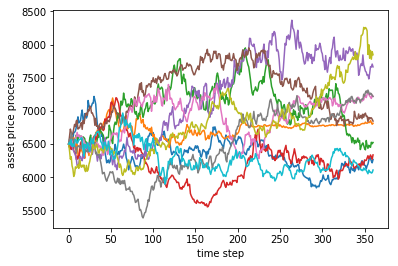

In [86]:
plt.plot(np.transpose(s[:10]));
plt.xlabel('time step')
plt.ylabel('asset price process')
plt.savefig('assetpath')

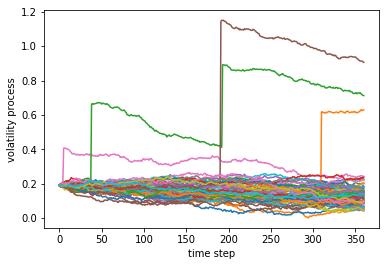

In [87]:
plt.plot(np.transpose(sp.sqrt(v[:70])));
plt.xlabel('time step')
plt.ylabel('volatility process')
plt.savefig('exactassetpath')

In [88]:
# Option pricing 
cp    = np.exp(-mu * m * dt) * np.maximum(s[:,-1]-k,0).mean()
cp

1261.9166993956092

In [89]:
#greeks

def deltafunc(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return scs.norm.cdf(d1) 

def gamma(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return scs.norm.pdf(d1) / (S * sigma * sp.sqrt(T))

def vega(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return S * sp.sqrt(T) * scs.norm.pdf(d1)

In [90]:
#Hedge 

D_BS      = np.zeros([n,m+1])
D         = np.zeros([n,m+1])


ttmmatrix = np.insert(ttm, 0, 0., axis=0)
ttmmatrix = np.tile(ttm, (n, 1))


In [93]:

#Merton jump diffusion prices 
#D[:,0] = 0
for i in range(series):
    if i == 0:
        factor = np.exp(- lambdd *T)
    else:
        sigma_i = np.sqrt(sigma_m**2 + (i * vol_m **2)/(T))
        r_i = r + lambdd *(1 - np.exp(EY))+ i *EY/T
        loglist = np.log([i for i in range (1,i +1)])
        factor = np.exp(- lambdd *T + i* np.log(lambdd*T)- np.sum(loglist))
    D_BS = deltafunc(s, k, T-ttmmatrix, sigma_i,r_i)
    D = D + factor*D_BS
np.shape(D)

MemoryError: 

In [94]:
#Lilis code from scratch
interest           = np.exp(r*dt)
balance            = cp - D[:,0]*s[:,0]

for i in range(1,m+1):
    timetomaturity = T - ttm[i-1]
    buy            = D[:,i] - D[:,i-1]
    cost           = buy*s[:,i]
    balance        = interest*balance - cost

St                 = s[:,-1]
liabilities        = np.array([st-k if st > k else 0 for st in St])

balance            = interest*balance + (D[:,-1])*s[:,-1] - np.array(liabilities)
finalbank          = list(balance)

finalbank          = [x/cp for x in finalbank]

C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


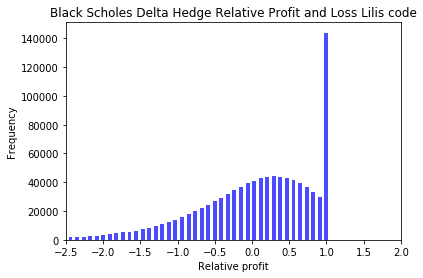

In [95]:
c, bins, patches = plt.hist(x=finalbank, bins=1500, color='b',alpha=0.7, rwidth=0.6)
plt.xlabel('Relative profit')
plt.ylabel('Frequency')
plt.title('Black Scholes Delta Hedge Relative Profit and Loss Lilis code')
maxfreq = c.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = -2.5, xmax=2)
plt.savefig('PnLMertonHedge1MioLili',transparent=T)
plt.show()


In [96]:
#code from https://www.maths.ox.ac.uk/system/files/attachments/M5_Delta%20Hedging%20using%20Merton%27s%20Jump%20Diffusion.pdf
#correct results for "known values"


st               = s[:,0]
amount           = cp
delta            = D[:,0]
Pnl              = amount - D[:,0]*st
interest         = np.exp(r* dt )

for i in range(1,m+1):
    t            = T-ttm[i-1]
    Pnl          = interest *Pnl
    newdelta     = D[:,i]
    Pnl          = Pnl - (newdelta-delta)*s[:,i]
    delta        = newdelta

Pnl              = Pnl* interest
ST               = s[:,-1]
PayoffCheck      = [k if sT >k  else 0 for sT in ST ]

PnL_final        = [ Pnl[i]+ PayoffCheck[i] for i in range(len(Pnl))]
delta_final      = [D[i,-1] -1 if PayoffCheck[i] == k else D[i,-1] for i in range(len(D[:,-1]))]

PnL_final        = PnL_final + delta_final * ST
PnL_final        = PnL_final/cp


C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


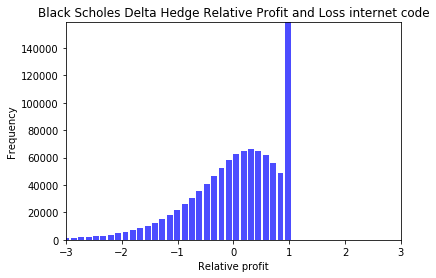

In [97]:
c, bins, patches = plt.hist(PnL_final, bins=1000, color='b',alpha=0.7, rwidth=0.8)

plt.xlabel('Relative profit')
plt.ylabel('Frequency')
plt.title('Black Scholes Delta Hedge Relative Profit and Loss internet code')

maxfreq = c.max()
plt.ylim(ymax = np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = -3, xmax = 3)
plt.savefig('PnLMertonDeltaHedge1MioInternet',transparent=T)
plt.show()